In [1]:
import itertools
from basics import *
from plotting import *
from plotting import savefig
from ase.io import read
import seaborn as sns
from scipy import stats

plt.style.use("paper")

## Obtaining the errors for the models

In [2]:
for name in ["finetune", "scratch"]:
    dset_path = os.path.join("../data", "02-mace-relax", f"{name}", "relax-test.xyz")

    dset = read(dset_path, index=":")

    df = []
    for i, at in enumerate(dset):
        df.append({
            "index": i,
            "crystal_id": at.info["crystal_id"],
            "nads": (at.numbers == 6).sum() - 1,
            "n_atoms": len(at),
            "true": at.info["energy"],
            "pred": at.info["MACE_energy"],
            "method": name,
        })

    df = pd.DataFrame(df)

    df["npred"] = df["pred"] / df["nads"]
    df["ntrue"] = df["true"] / df["nads"]

    df.to_csv(f"../data/02-mace-relax/{name}.csv")

In [3]:
df.sort_values("crystal_id")

,index,crystal_id,nads,n_atoms,true,pred,method,npred,ntrue
10,10,76,2,86,-1.572497,-1.518644,scratch,-0.759322,-0.786249
8,8,80,2,86,-1.582297,-1.589967,scratch,-0.794983,-0.791148
6,6,89,2,86,-1.508576,-1.524204,scratch,-0.762102,-0.754288
11,11,103,2,86,-1.636323,-1.504601,scratch,-0.752300,-0.818162
3,3,107,2,86,-1.587962,-1.559355,scratch,-0.779678,-0.793981
...,...,...,...,...,...,...,...,...,...
87,87,18401,9,124,-4.197955,-4.600743,scratch,-0.511194,-0.466439
96,96,18695,11,112,-4.692918,-5.246160,scratch,-0.476924,-0.426629
88,88,18698,12,130,-5.248302,-4.845727,scratch,-0.403811,-0.437358
89,89,18895,14,134,-3.337797,-3.296248,scratch,-0.235446,-0.238414


## Obtaining the errors for the delta learning models

In [4]:
path_1 = os.path.join("../data", "02-mace-relax", "delta", "full-test.xyz")
path_2 = os.path.join("../data", "02-mace-relax", "delta", "relax-test.xyz")

dset_1 = read(path_1, index=":")
dset_2 = read(path_2, index=":")

df = []
for i, (at1, at2) in enumerate(zip(dset_1, dset_2)):
    bind = at1.info["MACE_energy"]
    delta = at2.info["MACE_energy"]
    
    df.append({
        "index": i,
        "crystal_id": at1.info["crystal_id"],
        "nads": (at1.numbers == 6).sum() - 1,
        "n_atoms": len(at1),
        "true_delta": at1.info["delta_energy"],
        "pred_delta": delta,
        "pred_unrelax": bind,
        "true": at1.info["energy"],
        "pred": bind + delta,
        "method": "delta",
    })

df = pd.DataFrame(df)

df["npred"] = df["pred"] / df["nads"]
df["ntrue"] = df["true"] / df["nads"]

df.to_csv(f"../data/02-mace-relax/delta.csv")

## Ploting the model performance

In [5]:
NAMES = ["finetune", "scratch", "delta"]

In [6]:
df = []
for name in NAMES:
    _df = pd.read_csv(f"../data/02-mace-relax/{name}.csv", index_col=0)
    df.append(_df)
    
df = pd.concat(df)

In [7]:
extr = pd.read_csv("../data/02-mace-relax/extrap.csv", index_col=0)

In [8]:
def get_rmse(true, pred):
    err = pred - true
    return np.sqrt((err ** 2).mean())

def get_spearmanr(true, pred):
    r, _ = stats.spearmanr(true, pred)
    return r

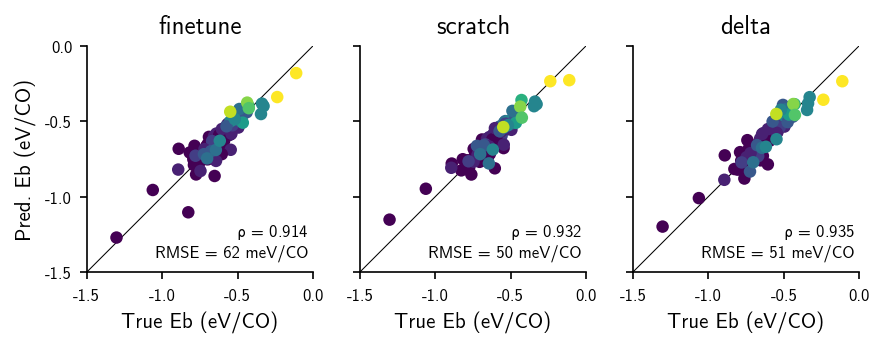

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(6, 4), sharex=True, sharey=True)

norm = plt.Normalize(3, 14)
lims = (-1.5, 0.0)
ticks = np.arange(-1.5, 0.1, 0.5)

for name, ax in zip(NAMES, axs):
    grp = df.loc[df.method == name]
    
    _x, _y = grp["ntrue"], grp["npred"]
    
    ax.scatter(
        _x,
        _y,
        c=grp["nads"],
        linewidths=0,
        norm=norm,
    )
    
    ax.set_aspect("equal")
    ax.plot(lims, lims, "k-", zorder=-1, linewidth=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(name)
    ax.set_xlabel("True Eb (eV/CO)")
    
    rmse = get_rmse(_x, _y) * 1000
    spearman = get_spearmanr(_x, _y)
    txt = (
        f"$\\rho$ = {spearman:.3f}" +
        "\n" +
        f"RMSE = {rmse:.0f} meV/CO"
    )
    ax.annotate(
        txt,
        (0.98, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        fontsize=8
    )

axs[0].set_ylabel("Pred. Eb (eV/CO)")
fig.tight_layout()
plt.show()

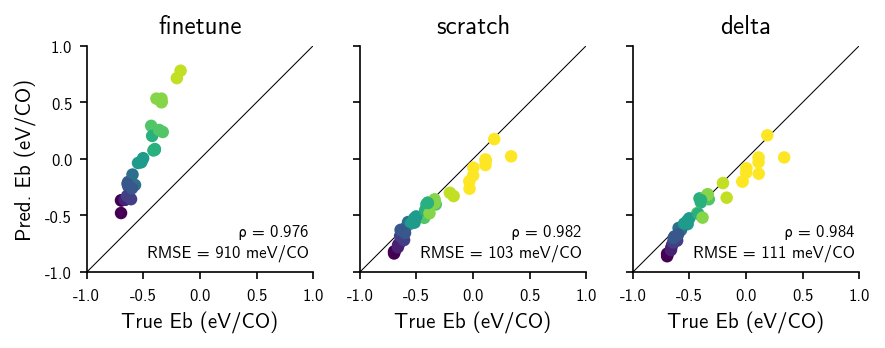

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(6, 4), sharex=True, sharey=True)

norm = plt.Normalize(3, 14)
lims = (-1.0, 1.0)
ticks = np.arange(lims[0], lims[1] + 0.1, 0.5)

for name, ax in zip(NAMES, axs):    
    _x, _y = extr["ntrue"], extr[f"npred_{name}"]
    
    ax.scatter(
        _x,
        _y,
        c=extr["nads"],
        linewidths=0,
        norm=norm,
    )
    
    ax.set_aspect("equal")
    ax.plot(lims, lims, "k-", zorder=-1, linewidth=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(name)
    ax.set_xlabel("True Eb (eV/CO)")
    
    rmse = get_rmse(_x, _y) * 1000
    spearman = get_spearmanr(_x, _y)
    txt = (
        f"$\\rho$ = {spearman:.3f}" +
        "\n" +
        f"RMSE = {rmse:.0f} meV/CO"
    )
    ax.annotate(
        txt,
        (0.98, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        fontsize=8
    )

axs[0].set_ylabel("Pred. Eb (eV/CO)")
fig.tight_layout()
plt.show()